In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from functions.utility import *

# Metrics

In [2]:
from functions.metrics import *
"""
Test that metric functions behave as expected for perfect similarity:
MSE, MAE, RMSE = 0.
PSNR = infinity.
SSIM = 1.
"""
im = get_im("boss_baby.jpg")

all_metrics(im, im)

MSE: 0.0
RMSE: 0.0
MAE: 0.0
PSNR: inf
SSIM: 1.0




# Test Upsampling

QUESTION - We want to upsample while in the [0,1] floating point range, but do we want to convert back to uint8 [0, 255] format before measuring metrics, or stay in floating point range?

Answer - we will probably want to convert back to uint8 [0, 255] for the visual aspect, but this will obviously result in some error as we are translating the floating point space into a larger space of values. This will give me a chance to put my numerical analysis skills to use.

MSE: 0.026743507002288065
RMSE: 0.16353442146009525
MAE: 0.1856083596844046
PSNR: 63.85862003122439
SSIM: 0.9998557062268769


MSE 0.026743507002288065
RMSE 0.16353442146009525
MAE 0.1856083596844046
PSNR 63.85862003122439
SSIM 0.9998557062268769


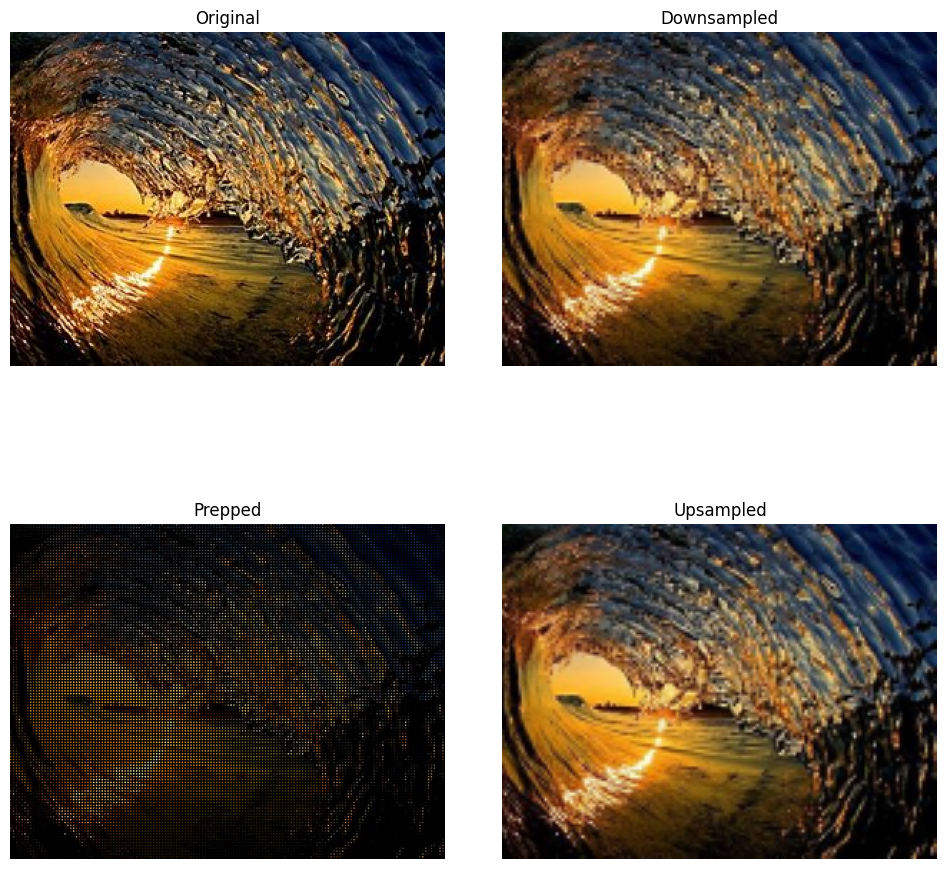

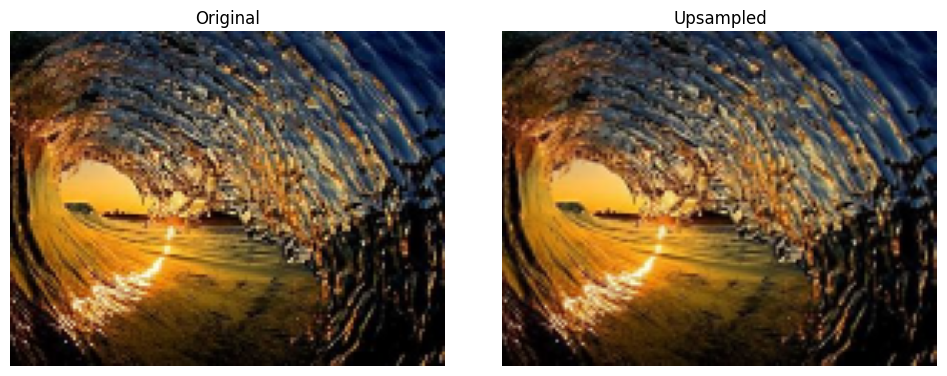

In [3]:
from functions.sampling import *
"""
Test upsampling for prepped approach.
"""
filename = 'wave.jpg'
im = get_im(filename).astype(float) / 255.
im = make_even_shape(im)

smaller_im = cv2_downsample(im)
prepped_im = prep_upsample(smaller_im)

upsampled_im = KNN_upsample_prepped(prepped_im, k=1)

display_prepped_upsampling_results([im, smaller_im, prepped_im, upsampled_im], path='prep_' + filename)

all_metrics(im, upsampled_im)

"""
Test upsampling for no-prep approach.
"""
im = get_im(filename).astype(float) / 255.
im = make_even_shape(im)

smaller_im = cv2_downsample(im)

upsampled_im = KNN_upsample_no_prep(smaller_im, k=1)

display_upsampling_results(smaller_im, upsampled_im, path='up_' + filename)

all_metrics(im, upsampled_im)

In [ ]:
"""
Test upsampling for no-prep approach with variable factor.
"""
im = get_im(filename).astype(float) / 255.
im = make_even_shape(im)
print("Original shape", im.shape)

upsampled_im = KNN_upsample_variable_factor(im, k=1, factor=3)
print("Result (upsampled) shape", upsampled_im.shape)

display_upsampling_results(im, upsampled_im, path='var_' + filename)

# Cannot compute metrics when upsampling to a shape dissimilar from the original image
# Perhaps we can use library functions to reshape/resize the orignal image to our target and then compute metrics

In [ ]:
"""
Test upsampling for no-prep approach with variable and dissimilar factors in both dimensions.
"""
filename = 'boss_baby.jpg' # remove later
im = get_im(filename).astype(float) / 255.
im = make_even_shape(im)
print("Original shape", im.shape)

upsampled_im = KNN_upsample_variable_factors(im, k=2, factor1=2, factor2=4)
print("Result shape", upsampled_im.shape)

display_upsampling_results(im, upsampled_im, path='dyn_h_' + filename)



im = get_im(filename).astype(float) / 255.
im = make_even_shape(im)
print("Original shape", im.shape)

upsampled_im = KNN_upsample_variable_factors(im, k=2, factor1=5, factor2=2)
print("Result shape", upsampled_im.shape)

display_upsampling_results(im, upsampled_im, path='dyn_v_' + filename)


# Cannot compute metrics when upsampling to a shape dissimilar from the original image
# We can compute matrics with respect to the aspect ratio being converted